In [1]:
import pandas as pd
import numpy as np

import keras
import tensorflow as tf

config = tf.ConfigProto(device_count={"CPU": 8})
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from moby.constants import DATA_DIR



def prepare_image(img_name, img_dir):
    """
    """
    img = image.load_img(
        img_dir/img_name,
        target_size=(100, 100, 3)
    )
    img_array = image.img_to_array(img)
    img_matrix = preprocess_input(img_array)
    return img_matrix


def build_tensor(label_map: dict, img_dir):
    """Build our tensor and return a label encoder.
    """
    n = len(label_map)
    tensor = np.zeros((n, 100, 100, 3))

    labels = list()
    label_encoder = LabelEncoder()

    for i, (img, label) in enumerate(label_map.items()):
        labels.append(label)
        tensor[i] = prepare_image(img, img_dir)

    integer_encoded = label_encoder.fit_transform(labels)
    # ['whale_A', 'whale_B', ...] -> [0, 1, ... ]
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    # [0 , 1, ...] -> [ [0], [1], ... ]

    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # [ [0], [1], ...] -> [[1, 0, 0], [0, 1, 0], ...]
    # i.e. Given an array with 10 features, and 20 observations, a one-hot encode
    # will produce a matrix with 20 rows and 10 columns, where in each row, a 1
    # is assigned to the column representing the feature observed.

    # We need the one-hot encoding for our model
    # we need to use the label encoder to get back our original whale IDs
    return tensor, onehot_encoded, label_encoder

Using TensorFlow backend.


In [2]:
training_data = pd.read_csv(DATA_DIR / "interim" / "1_no_new_whales" / "train.csv")
training_img_dir = DATA_DIR / "interim" / "1_no_new_whales" / "train"

In [3]:
label_map = training_data.set_index("Image", verify_integrity=True)["Id"].to_dict()

In [4]:
tensor, onehot, label = build_tensor(label_map, training_img_dir)

/home/ttu/.local/share/virtualenvs/TheWhaleFormerlyKnownAsMoby-M9BPs1zq/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
onehot.shape

(15697, 5004)

In [6]:
from keras import layers
from keras.models import Sequential

model = Sequential()

model.add(layers.Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

model.add(layers.BatchNormalization(axis = 3, name = 'bn0'))
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2), name='max_pool'))
model.add(layers.Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(layers.Activation('relu'))
model.add(layers.AveragePooling2D((3, 3), name='avg_pool'))

model.add(layers.Flatten())
model.add(layers.Dense(500, activation="relu", name='rl'))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(onehot.shape[1], activation='softmax', name='sm'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 15, 15, 64)        0         
__________

In [7]:
history = model.fit(tensor, onehot, epochs=100, batch_size=100, verbose=1)

Epoch 1/100
15697/15697 [==============================] - 251s 16ms/step - loss: 8.4273 - acc: 0.0029
Epoch 2/100
15697/15697 [==============================] - 251s 16ms/step - loss: 8.1614 - acc: 0.0034
Epoch 3/100
15697/15697 [==============================] - 250s 16ms/step - loss: 8.0819 - acc: 0.0044
Epoch 4/100
15697/15697 [==============================] - 251s 16ms/step - loss: 7.9905 - acc: 0.0075
Epoch 5/100
15697/15697 [==============================] - 253s 16ms/step - loss: 7.8943 - acc: 0.0108
Epoch 6/100
15697/15697 [==============================] - 255s 16ms/step - loss: 7.7687 - acc: 0.0118
Epoch 7/100
15697/15697 [==============================] - 255s 16ms/step - loss: 7.6433 - acc: 0.0169
Epoch 8/100
15697/15697 [==============================] - 254s 16ms/step - loss: 7.4812 - acc: 0.0187
Epoch 9/100
15697/15697 [==============================] - 253s 16ms/step - loss: 7.3084 - acc: 0.0217
Epoch 10/100
15697/15697 [==============================] - 254s 16ms/ste

In [9]:
model.save("./CNN_first_pass_no_new_whales.h5")

# Sample Prediction (Scratch)

In [11]:
test_images = DATA_DIR / "raw" / "test" 

x = next(test_images.glob("*jpg"))
my_img = prepare_image(x, test_images)

In [13]:
test_imgs = np.zeros((1, 100, 100, 3))
test_imgs[0]= my_img


array([[2.8067821e-09, 2.3171715e-07, 8.9690775e-07, ..., 5.5238349e-14,
        5.8274452e-15, 1.5638869e-14]], dtype=float32)

In [17]:
pred = model.predict(test_imgs)

In [29]:
pred[0]

array([2.8067821e-09, 2.3171715e-07, 8.9690775e-07, ..., 5.5238349e-14,
       5.8274452e-15, 1.5638869e-14], dtype=float32)

In [30]:
label.inverse_transform(pred.argsort()[0][-5:][::-1])

array(['w_6ed6320', 'w_fd6a3ad', 'w_e13f4e8', 'w_456646a', 'w_8f0c6ed'],
      dtype='<U9')

In [46]:
training_data.query("Id == 'w_8f0c6ed'")

,Image,Id
500,0823f9df3.jpg,w_8f0c6ed
9412,9a370a86c.jpg,w_8f0c6ed
10039,a440f35fa.jpg,w_8f0c6ed
10398,a9ab92cef.jpg,w_8f0c6ed
11140,b5bf598c6.jpg,w_8f0c6ed
12511,cbabc03bd.jpg,w_8f0c6ed
13009,d3db45707.jpg,w_8f0c6ed
13367,d99e5b26b.jpg,w_8f0c6ed


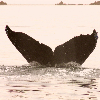

In [50]:
image.array_to_img(prepare_image('0823f9df3.jpg', training_img_dir))

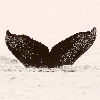

In [34]:
image.array_to_img(my_img)

In [53]:
model.save_weights("./CNN_first_pass_no_new_whales_weights.h5")